# imports

In [11]:
import pandas as pd
import numpy as np
import sklearn
import pickle 
import time 
import datetime
import warnings
warnings.filterwarnings('ignore')

In [12]:
%run function_proposed_gcn.py

In [13]:
with open('fraudTrain.pkl', 'rb') as file:
    fraudTrain = pickle.load(file)    

In [14]:
df = fraudTrain[::10]

df = df.reset_index(drop=True)

df.is_fraud.mean()

# df_train, df_test = sklearn.model_selection.train_test_split(df)

0.005807854431707643

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import sklearn
import xgboost as xgb

# sklearn
from sklearn import model_selection # split함수이용
from sklearn import ensemble # RF,GBM
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# gnn
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv


In [16]:
def down_sample_textbook(df):
    df_majority = df[df.is_fraud==0].copy()
    df_minority = df[df.is_fraud==1].copy()
    df_maj_dowsampled = sklearn.utils.resample(df_majority, n_samples=len(df_minority), replace=False, random_state=42)
    df_downsampled = pd.concat([df_minority, df_maj_dowsampled])
    return df_downsampled

def compute_time_difference(group):
    n = len(group)
    result = []
    for i in range(n):
        for j in range(n):
            time_difference = abs(group.iloc[i].trans_date_trans_time.value - group.iloc[j].trans_date_trans_time.value)
            result.append([group.iloc[i].name, group.iloc[j].name, time_difference])
    return result

def mask(df):
    df_tr,df_test = sklearn.model_selection.train_test_split(df, random_state=42)
    N = len(df)
    train_mask = [i in df_tr.index for i in range(N)]
    test_mask = [i in df_test.index for i in range(N)]
    train_mask = np.array(train_mask)
    test_mask = np.array(test_mask)
    return train_mask, test_mask

def edge_index_selected(edge_index):
    theta = edge_index[:,2].mean()
    edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta))
    edge_index = edge_index.tolist()
    mean_ = np.array(edge_index)[:,2].mean()
    selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > mean_]
    edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()
    return edge_index_selected



In [17]:
df.shape

(104858, 22)

In [18]:
train_mask, test_mask = mask(df)
df_tr,df_test = sklearn.model_selection.train_test_split(df, random_state=42)

In [19]:
# groups = df.groupby('cc_num')
# edge_index_list_plus = [compute_time_difference(group) for _, group in groups]
# edge_index_list_plus_flat = [item for sublist in edge_index_list_plus for item in sublist]
# edge_index_list_plus_nparr = np.array(edge_index_list_plus_flat)
# np.save('edge_index_list_plus_005.npy', edge_index_list_plus_nparr)

In [20]:
edge_index = np.load('edge_index_list_plus_005.npy').astype(np.float64)
edge_index.shape

(15990358, 3)

In [21]:
edge_index[:,2].mean()

1.1661268505973428e+16

(array([3295084., 2862306., 2479784., 2167346., 1785280., 1358708.,
        1001646.,  663712.,  286718.,   89774.]),
 array([0.0000000e+00, 3.7535640e+15, 7.5071280e+15, 1.1260692e+16,
        1.5014256e+16, 1.8767820e+16, 2.2521384e+16, 2.6274948e+16,
        3.0028512e+16, 3.3782076e+16, 3.7535640e+16]),
 <BarContainer object of 10 artists>)

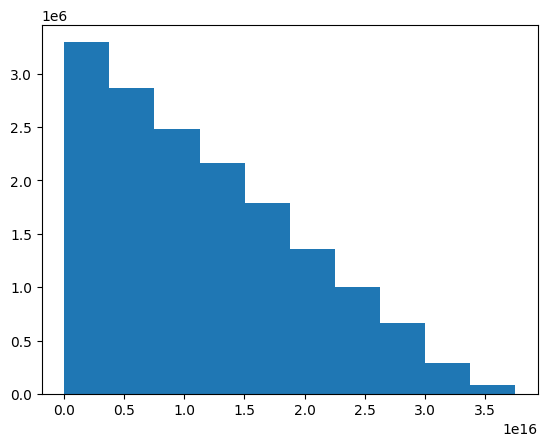

In [46]:
plt.hist(edge_index[:,2])

In [51]:
2.5e16 > 1.16e16

True

In [52]:
theta = 2.5e16

In [53]:
edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta))

In [54]:
edge_index = edge_index.tolist()

In [56]:
np.array(edge_index)[:,2].mean()

0.6541518297734155

(array([ 104858.,       0.,  367350., 1557012., 2109832., 2399724.,
        2431610., 2400986., 2332404., 2286582.]),
 array([0.        , 0.09999976, 0.19999952, 0.29999928, 0.39999904,
        0.4999988 , 0.59999856, 0.69999832, 0.79999808, 0.89999784,
        0.9999976 ]),
 <BarContainer object of 10 artists>)

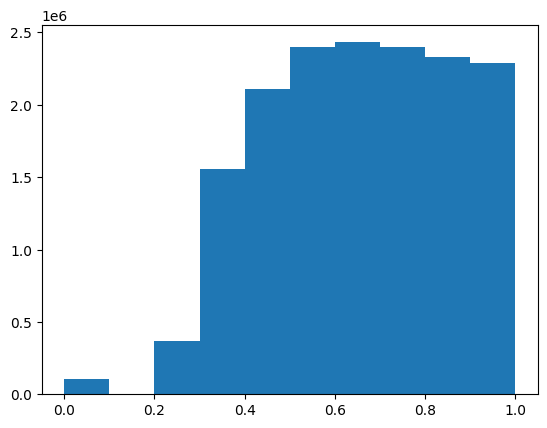

In [57]:
plt.hist(np.array(edge_index)[:,2])

In [70]:
selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > 0.9]
edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()

In [72]:
x = torch.tensor(df['amt'], dtype=torch.float).reshape(-1,1)
y = torch.tensor(df['is_fraud'],dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index_selected, y=y, train_mask = train_mask, test_mask = test_mask)
data

Data(x=[104858, 1], edge_index=[2, 2286540], y=[104858], train_mask=[104858], test_mask=[104858])

In [71]:
edge_index_selected.shape

torch.Size([2, 2286540])

In [73]:
torch.manual_seed(202250926)

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

X = (data.x[data.train_mask]).numpy()
XX = (data.x[data.test_mask]).numpy()
y = (data.y[data.train_mask]).numpy()
yy = (data.y[data.test_mask]).numpy()

model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
model.eval()

pred = model(data).argmax(dim=1) # argmax말고
yyhat = pred[data.test_mask]

pred

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results1= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석1'])
_results1

,accuracy_score,precision_score,recall_score,f1_score
분석1,0.994202,0.0,0.0,0.0


In [118]:
yyhat.sum()

tensor(0)

In [74]:
gnn_fpr, gnn_tpr, gnn_thresholds  = roc_curve(yy, yyhat)
gnn_roc_auc_lr = auc(gnn_fpr, gnn_tpr)
gnn_roc_auc_lr

0.5

---

In [75]:
theta = 0.5e16

In [76]:
edge_index = np.load('edge_index_list_plus_005.npy').astype(np.float64)
edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta))

In [77]:
edge_index = edge_index.tolist()

In [78]:
np.array(edge_index)[:,2].mean()

0.24202248967016632

(array([7297668., 2256502., 1485530., 1114218.,  886792.,  727340.,
         651226.,  577800.,  518864.,  474418.]),
 array([0.       , 0.0999988, 0.1999976, 0.2999964, 0.3999952, 0.499994 ,
        0.5999928, 0.6999916, 0.7999904, 0.8999892, 0.999988 ]),
 <BarContainer object of 10 artists>)

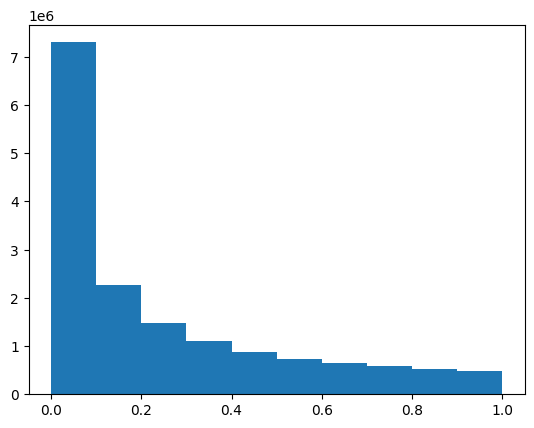

In [79]:
plt.hist(np.array(edge_index)[:,2])

In [80]:
selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > 0.8]
edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()

In [83]:
x = torch.tensor(df['amt'], dtype=torch.float).reshape(-1,1)
y = torch.tensor(df['is_fraud'],dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index_selected, y=y, train_mask = train_mask, test_mask = test_mask)
data

Data(x=[104858, 1], edge_index=[2, 993216], y=[104858], train_mask=[104858], test_mask=[104858])

In [84]:
edge_index_selected.shape

torch.Size([2, 993216])

In [85]:
torch.manual_seed(202250926)

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

X = (data.x[data.train_mask]).numpy()
XX = (data.x[data.test_mask]).numpy()
y = (data.y[data.train_mask]).numpy()
yy = (data.y[data.test_mask]).numpy()

model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
model.eval()

pred = model(data).argmax(dim=1) # argmax말고
yyhat = pred[data.test_mask]

pred

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results1= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석1'])
_results1

,accuracy_score,precision_score,recall_score,f1_score
분석1,0.994202,0.0,0.0,0.0


In [86]:
gnn_fpr, gnn_tpr, gnn_thresholds  = roc_curve(yy, yyhat)
gnn_roc_auc_lr = auc(gnn_fpr, gnn_tpr)
gnn_roc_auc_lr

0.5

---

In [91]:
selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > 0.95]
edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()

In [93]:
x = torch.tensor(df['amt'], dtype=torch.float).reshape(-1,1)
y = torch.tensor(df['is_fraud'],dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index_selected, y=y, train_mask = train_mask, test_mask = test_mask)
data

Data(x=[104858, 1], edge_index=[2, 238640], y=[104858], train_mask=[104858], test_mask=[104858])

In [94]:
torch.manual_seed(202250926)

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

X = (data.x[data.train_mask]).numpy()
XX = (data.x[data.test_mask]).numpy()
y = (data.y[data.train_mask]).numpy()
yy = (data.y[data.test_mask]).numpy()

model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
model.eval()

pred = model(data).argmax(dim=1) # argmax말고
yyhat = pred[data.test_mask]

pred

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results1= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석1'])
_results1

,accuracy_score,precision_score,recall_score,f1_score
분석1,0.994202,0.0,0.0,0.0


In [95]:
gnn_fpr, gnn_tpr, gnn_thresholds  = roc_curve(yy, yyhat)
gnn_roc_auc_lr = auc(gnn_fpr, gnn_tpr)
gnn_roc_auc_lr

0.5

In [100]:
model(data)[:,1]

tensor([-8.5130, -7.5498, -7.2450,  ..., -6.0895, -7.1428, -6.7693],
       grad_fn=<SelectBackward0>)

In [111]:
model(data)[data.test_mask][:,0].mean()

tensor(-0.0059, grad_fn=<MeanBackward0>)

In [112]:
model(data)[data.test_mask][:,1].mean()

tensor(-7.0153, grad_fn=<MeanBackward0>)

In [116]:
model(data)[data.test_mask]

tensor([[-5.7895e-04, -7.4546e+00],
        [-5.3886e-03, -5.2262e+00],
        [-1.2064e-03, -6.7207e+00],
        ...,
        [-2.4151e-03, -6.0272e+00],
        [-4.8757e-04, -7.6263e+00],
        [-1.1491e-03, -6.7693e+00]], grad_fn=<IndexBackward0>)

In [ ]:
train에는 df50으로 학습하고 test는 0.005